# マルチレイヤーネットワーク

前のユニットでは、1層の密なニューラルネットワークを使って手書きの数字を分類しました。今回は、層を増やすことで精度が向上するかどうかを見てみましょう。

前のユニットと同様に、`pytorchcv`ヘルパーを使って、前のユニットで定義したすべての関数をロードします。

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary

from pytorchcv import load_mnist, train, plot_results
load_mnist(batch_size=128)

## 多層パーセプトロン

多層ネットワークでは、1つまたは複数の**hidden layers**を追加します。

![入力層と出力層の間に隠れ層を設けた多層ネットワークのイメージ図](images/dense-multilayer-network.png)

この層には任意の数のニューロンを含めることができますが、これはニューラルネットワークの性能、すなわちパラメータの数に影響します。ネットワークのパラメータが多ければ多いほど、学習に必要なデータ量も多くなります。

しかし、多ければ良いというものではありません。**オーバーフィッティング**を防ぐためには、データセットのサイズに応じてニューラルネットワークのいくつかのパラメータを選択する必要があります。

ネットワークのレイヤー構造は以下のようになります。

![ネットワークのレイヤー構造を細分化したイメージ図](images/multilayer-network-layers.png)

ここで重要なのは、**ReLU**と呼ばれる非線形活性化関数層です。ニューラルネットワークが高い表現力を発揮する理由のひとつに、この非線形活性化関数があるからです。ニューラルネットワークが高い表現力を持つ理由のひとつは、この非線形活性化関数にあります。確かに、ネットワークが線形層の連続で構成されていれば、本質的には1つの線形層と同じであることが数学的に証明できます。ですから、層と層の間に非線形関数を挿入することが重要なのです

ここでは、よく使われる2つの活性化関数について説明します。

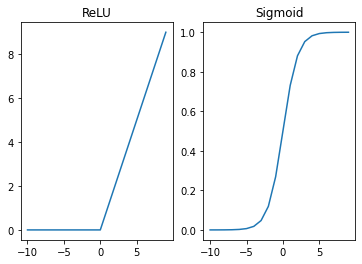

In [2]:
def plot_function(f,name=''):
    plt.plot(range(-10,10), [f(torch.tensor(x,dtype=torch.float32)).item() for x in range(-10,10)])
    plt.title(name)

plt.subplot(121)
plot_function(torch.relu,'ReLU')
plt.subplot(122)
plot_function(torch.sigmoid,'Sigmoid')

ネットワークは、PyTorchの`Sequential`構文を使って、以下のように定義できます。

In [3]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=0))

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

ここでは、`torchsummary.summary()`関数を使って、ネットワークの層ごとの詳細な構造と、その他の有用な情報を表示します。特に、ネットワークのパラメータの数を見ることができます。

それでは、この多層パーセプトロンを学習してみましょう。

Epoch  0, Train acc=0.931, Val acc=0.954, Train loss=0.023, Val loss=0.022
Epoch  1, Train acc=0.961, Val acc=0.961, Train loss=0.022, Val loss=0.022
Epoch  2, Train acc=0.968, Val acc=0.963, Train loss=0.021, Val loss=0.022
Epoch  3, Train acc=0.972, Val acc=0.963, Train loss=0.021, Val loss=0.022
Epoch  4, Train acc=0.974, Val acc=0.967, Train loss=0.021, Val loss=0.022


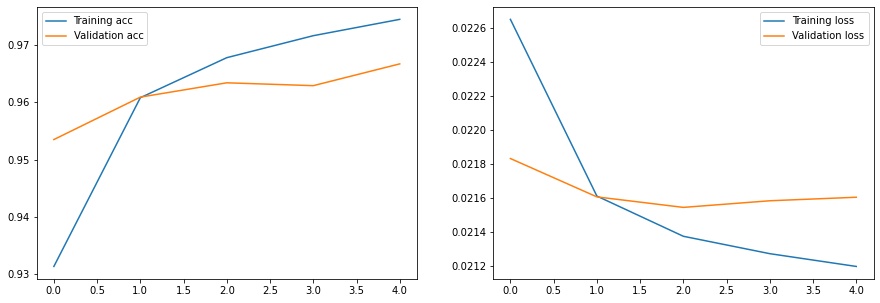

In [4]:
hist = train(net,train_loader,test_loader, epochs=5)
plot_results(hist)

以下の点に注意してください。

* このネットワークは、前のユニットで学習した1層のパーセプトロンよりも表現力が豊かです。このネットワークは、前のユニットで学習した1層のパーセプトロンよりも表現力が高いため、学習精度が非常に高く、パラメータ数が十分に多い場合には、ほぼ100％の学習精度を得ることができます。
* 検証精度の上昇が止まると、モデルの汎化能力が限界に達したことを意味し、これ以上の学習はオーバーフィッティングになる可能性が高くなります。

## クラスベースのネットワーク定義

レイヤのリストとして `Sequential` スタイルを使用してモデルを定義することは、非常に便利なように見えますが、多少の制限があります。重みを共有したり、レイヤー間の非線形接続を含む、より複雑なネットワークを定義する必要がある場合もあるでしょう。

In [5]:
from torch.nn.functional import relu,log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x,dim=0)
        return x

net = MyNet()

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

ニューラルネットワークの構造は、`Sequential`で定義されたネットワークと同じですが、定義がより明確になっていることがわかります。当社のカスタムニューラルネットワークは、[``torch.nn.Module``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)のクラスを継承したクラスで表現されています。

クラスの定義は2つの部分で構成されています。
* コンストラクタ(`__init__`)では、ネットワークが持つすべての層を定義します。これらの層はクラスの内部変数として保存され、PyTorchは学習時にそれらの層のパラメータを最適化すべきかどうかを自動的に判断します。内部的には、PyTorchは`parameters()`メソッドを使って学習可能なパラメータを探し、`nn.Module`は全てのサブモジュールから学習可能なパラメータを自動的に収集します。
* ニューラルネットワークのフォワードパス計算を行う`forward`メソッドを定義します。ここでは，パラメータテンソル `x` から始めて，それを明示的にすべての層と活性化関数に通し， `flatten` から始めて，最終的な線形層 `out` に至るまでの計算を行います．out = net(x)`と書いてニューラルネットワークを入力データ`x`に適用すると、`forward`メソッドが呼び出されます。

実際、`Sequential`ネットワークもよく似た方法で表現されており、レイヤーのリストを保存し、フォワードパスの間に順次適用していくだけです。ここでは、このプロセスをより明示的に表現することで、より柔軟性を持たせることができます。これが、ニューラルネットワークの定義にクラスを使用することが推奨される理由の一つです。

次に、ネットワークをトレーニングして、以前と同じような結果が得られることを確認します。

Epoch  0, Train acc=0.931, Val acc=0.956, Train loss=0.023, Val loss=0.022
Epoch  1, Train acc=0.960, Val acc=0.962, Train loss=0.022, Val loss=0.022
Epoch  2, Train acc=0.967, Val acc=0.964, Train loss=0.021, Val loss=0.022
Epoch  3, Train acc=0.970, Val acc=0.961, Train loss=0.021, Val loss=0.022
Epoch  4, Train acc=0.972, Val acc=0.963, Train loss=0.021, Val loss=0.022


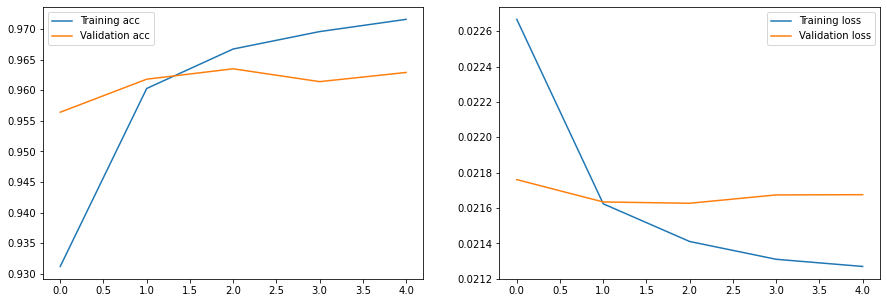

In [6]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

## 覚えておくべき重要点

マルチレベルネットワークは、単層パーセプトロンよりも高い精度を得ることができますが、コンピュータビジョンのタスクには完璧ではありません。画像の中には、物体の位置に関わらず、その物体を分類するのに役立つ構造的なパターンがありますが、パーセプトロンではそのようなパターンを抽出し、選択的に探すことができません。次のユニットでは、コンピュータビジョンのタスクに効果的に使用できる、特殊なタイプのニューラルネットワークに焦点を当てます。